In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image
import tensorflow as tf
import PIL
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow import keras

In [2]:
data = pd.read_csv(r"C:\Users\NEW\Documents\Machine Learning Lab\vehcle_img_data.csv")
data = data.iloc[0:5000]

C:\Users\NEW\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
data.dropna(inplace=True)

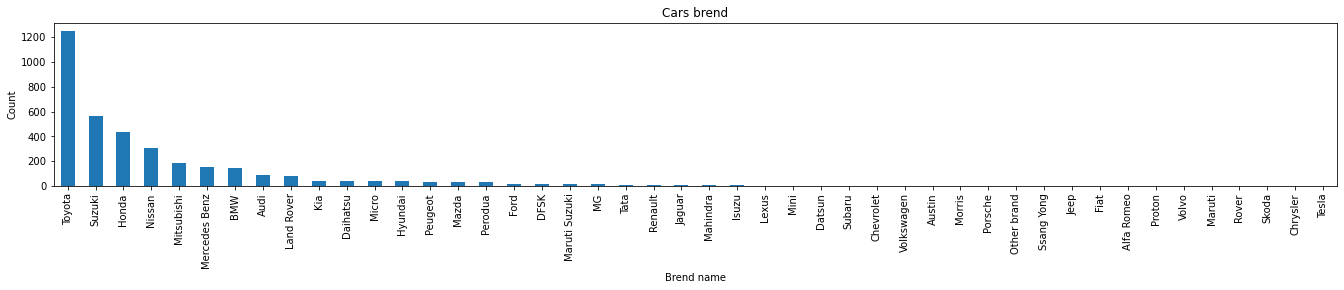

In [4]:
data.Brand.value_counts().plot(kind='bar', figsize=(23, 3))
# commenting the plot 
plt.title("Cars brend")
plt.xlabel("Brend name")
plt.ylabel("Count"); 

In [5]:
data.shape

(3660, 10)

In [6]:
import os
x = os.listdir("C:/Users/NEW/Documents/Machine Learning Lab/vehicle_images/vehicle_images")
len(x)

77977

In [7]:
data.Image_Path = '../vehicle_images/' + data.Image_Path.str.replace('./','', regex=False)
data.iloc[0]

Image_Path      ../vehicle_images/vehicle_images/1633889154186...
Brand                                                      Toyota
Model                                                       Hilux
Edition                                                     Hilux
Year                                                         2006
Condition                                                    Used
Transmission                                               Manual
Body                                                    SUV / 4x4
Fuel                                                       Diesel
Capacity                                                 2,500 cc
Name: 0, dtype: object

In [8]:
X = data.Image_Path

In [9]:
y = data.Brand

In [10]:
data['Image_Path'] = 'vehicle_images/'+data['Image_Path']

In [11]:
#print(y[4])
#display(Image(X[4]))

In [12]:
#categorial encoding
def transformer(brand):
    brand_names = brand.value_counts().index
    n = len(brand_names)
    categories = dict(zip(brand_names, range(n)))
    brand.replace(categories, inplace=True)
    return categories

In [13]:
transformer(y)

{'Toyota': 0,
 'Suzuki': 1,
 'Honda': 2,
 'Nissan': 3,
 'Mitsubishi': 4,
 'Mercedes Benz': 5,
 'BMW': 6,
 'Audi': 7,
 'Land Rover': 8,
 'Kia': 9,
 'Daihatsu': 10,
 'Micro': 11,
 'Hyundai': 12,
 'Peugeot': 13,
 'Mazda': 14,
 'Perodua': 15,
 'Ford': 16,
 'DFSK': 17,
 'Maruti Suzuki': 18,
 'MG': 19,
 'Tata': 20,
 'Renault': 21,
 'Jaguar': 22,
 'Mahindra': 23,
 'Isuzu': 24,
 'Lexus': 25,
 'Mini': 26,
 'Datsun': 27,
 'Subaru': 28,
 'Chevrolet': 29,
 'Volkswagen': 30,
 'Austin': 31,
 'Morris': 32,
 'Porsche': 33,
 'Other brand': 34,
 'Ssang Yong': 35,
 'Jeep': 36,
 'Fiat': 37,
 'Alfa Romeo': 38,
 'Proton': 39,
 'Volvo': 40,
 'Maruti': 41,
 'Rover': 42,
 'Skoda': 43,
 'Chrysler': 44,
 'Tesla': 45}

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1)

In [15]:
def image_processing(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, size=[220, 220])
    return img

In [16]:
def image_labelling(img_path, label):
    img = image_processing(img_path)
    return img, label

In [17]:
#from torch.nn import ReLU

def classification_model():
    data_handling = Sequential([
        layers.RandomFlip('horizontal', input_shape=(220, 220, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1)
    ])
    
    model = Sequential([
        data_handling,
        Conv2D(32, 5, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        Conv2D(32, 5, padding='same', activation='relu'),
        layers.MaxPooling2D(),

        Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),

        Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        
        layers.Dense(51, layers.Dense(51, activation='softmax'))
    ])
    
    model.compile(optimizer = tf.keras.optimizers.SGD(), 
                 loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])
    
    return model

model = classification_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 220, 220, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 32)      25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 55, 55, 64)       

In [18]:
def create_batches(X,y):
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data = data.map(image_labelling)
    batches = data.batch(256)
    return batches

In [19]:
train_set = create_batches(X_train, y_train)
test_set = create_batches(X_test, y_test)

In [ ]:
stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
no_of_epochs = 10

def training():
    model = classification_model()
    history = model.fit(train_set, epochs = no_of_epochs, validation_data=test_set, callbacks = [stopping])
    return model, history

model, history = training()

Epoch 1/10
10/12 [========================>.....] - ETA: 42s - loss: 3.8349 - accuracy: 0.1590 

In [ ]:
data.head()